# SpikeInterface Tutorial - Spike Sorting Workshop - Edinburgh 2019


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. We will be using the `spikeintrface` from the SpikeInterface github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

For this analysis, we will be using a simulated dataset from [MEArec](https://github.com/alejoe91/MEArec). We will show how to:

- load the data with spikeextractors package
- load a probe file
- preprocess the signals
- run a popular spike sorting algorithm with different parameters
- curate the spike sorting output using Phy
- compare with ground-truth information
- run consensus-based spike sorting


For this tutorial we will need the following packages:
- spikeinterface
- MEArec
- klusta
- phy
- matplotlib

+ all their dependencies.

To install those you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

If you use a conda environment, you can create the `spiketutorial` environment with:

`conda env create -f environment.yml`

You might need to run:

`ipython kernel install --user --name=tutorial`

or:

`conda install nb_conda_kernels` and change Kernel to run the tutorial notebook.

### Downloading the recording

First, we need to download the recording. Feel free to use your own recordings as well later on.

From this Zenodo [link](https://zenodo.org/record/3256071#.XRHqhnX7Q5k), you can download the simulated dataset mentioned above. Move the dataset in the current folder.

The recording was generated on a shank probe with 4 tetrodes separated by 300 $\mu$m. It has 36 cells in total, distributed in the proximity of the 4 tetrodes. The recording is 30 s long and there is an additive noise level of 10 $\mu$V.

### Importing the modules

Let's now import the `spikeinterface` modules that we need.

In [1]:
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as sorters
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pylab as plt
import numpy as np
%matplotlib notebook

11:59:23 [I] klustakwik KlustaKwik2 version 0.2.6


### Loading recording and probe information

In [2]:
recording_file = 'recordings_36cells_four-tetrodes_30.0_10.0uV_20-06-2019_14_48.h5'
recording = se.MEArecRecordingExtractor(recording_file, locs_2d=True)

Could not load plane information. Assuming probe is in yz plane


In [3]:
se.SpikeGLXRecordingExtractor?

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The MEArecRecordingExtractor is designed specifically for MEArec datasets.

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [4]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Sampling frequency: 32000.0
Number of channels: 16


Let's plot the channel locations and a snippet of traces using `spikewidgets`:

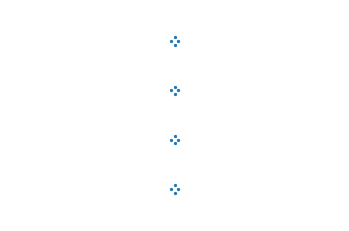

In [5]:
w_elec = sw.plot_electrode_geometry(recording, markersize=5)

The `get_traces()` function returns a NxT numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [6]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [7]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (16, 64000)


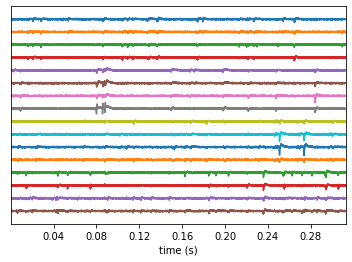

In [8]:
w_ts = sw.plot_timeseries(recording)

Each `spikewidgets` function returns a `Widget` object. You can access the figure and axes with the `figure` and `ax` fields:

In [9]:
w_ts.ax.axis('off')

(0.0, 0.3125, -482.63420174561605, 7722.147227929857)

We can see that the spikes mainly appear separately on different tetrodes. Each tetrode belongs to a different `group`. We can load the `group` information in two ways:

- using the `set_channel_groups` in your RecordingExtractor (manually loading group information)
- loading a probe file using the `load_probe_file` from `spikeextractors` (automatically loading group information)

Let's use the second option. Probe files (`.prb`) also enable users to change the channel map (reorder the channels) and add channel grouping properties and locations. In this case, our probe file will order the channels in reverse and split them in 4 groups, representing the 4 tetrodes.

In [10]:
!cat tetrode_16.prb

channel_groups = {
    # Tetrode index
    0:
      {
      'channels': [12, 13, 14, 15],
      },
    1:
      {
      'channels': [8, 9, 10, 11],
      },
    2:
      {
      'channels': [4, 5, 6, 7],
      },
    3:
      {
      'channels': [0, 1, 2, 3],
      },
}


In [11]:
recording_prb = se.load_probe_file(recording, 'tetrode_16.prb')

In [12]:
print('Original channels:', recording.get_channel_ids())
print('Channels after loading the probe file:', recording_prb.get_channel_ids())
print('Channel groups after loading the probe file:', recording_prb.get_channel_groups())

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channels after loading the probe file: [12, 13, 14, 15, 8, 9, 10, 11, 4, 5, 6, 7, 0, 1, 2, 3]
Channel groups after loading the probe file: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]


### Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording, remove channel 5, and apply common median reference to the original recording.

In [13]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f, bad_channels=[5])
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

Now we can extractor traces from the preprocessed recording.

In [14]:
trace_f_snippet = recording_f.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
trace_cmr_snippet = recording_cmr.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

print(trace_f_snippet.shape)
print(trace_cmr_snippet.shape)

(16, 64000)
(15, 64000)


We can plot the bandpassfiltered snippets below

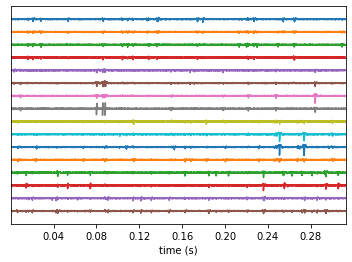

In [15]:
sw.plot_timeseries(recording_f, channels=range(16))

In [16]:
print('Channel ids for CMR recordings:', recording_cmr.get_channel_ids())
print('Channel groups for CMR recoridng:', recording_cmr.get_channel_groups())

Channel ids for CMR recordings: [12, 13, 14, 15, 8, 9, 10, 11, 4, 6, 7, 0, 1, 2, 3]
Channel groups for CMR recoridng: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]


### Spike sorting

We can now run spike sorting on the above recording. We will use `klusta` for this demonstration and we will run spike sorting on each group separately.

Let's first check the installed sorters in spiketoolkit to see if klusta is available. Then we can check the `klusta` default parameters.

We will sort the bandpass filtered recording (the `recording_bpf` object), as there is no external noise and all channels are good :)

In [17]:
sorters.installed_sorter_list

[spikesorters.klusta.klusta.KlustaSorter,
 spikesorters.spyking_circus.spyking_circus.SpykingcircusSorter]

In [18]:
sorters.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [19]:
sorters.run_sorter?

We will set the `adjacency_radius` to 50 microns as electrodes belonging to the same tetrode are within this distance.

In [20]:
# run spike sorting on entire recording
sorting_KL_all = sorters.run_klusta(recording_f, 
                                    output_folder='results_all_klusta', 
                                    adjacency_radius=50, delete_output_folder=True)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

Klusta units are not unique! Using unique unit ids
Found 33 units


In [21]:
# run spike sorting by group
sorting_KL_split = sorters.run_klusta(recording_f, adjacency_radius=50, 
                                      output_folder='results_split_klusta', 
                                      grouping_property='group')
print('Found', len(sorting_KL_split.get_unit_ids()), 'units')

Found 34 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [22]:
print('Units', sorting_KL_split.get_unit_ids())

Units [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [23]:
print('Units', sorting_KL_split.get_unit_spike_train(13))

Units [   778   8630  19976  20461  20803  21197  30380  32031  33417  37445
  42664  43908  52840  60575  74517  75345  78538  88577  92460  96640
 101570 103168 104267 109140 122925 145125 147068 147567 149308 153221
 161258 164164 167265 170105 170216 177077 188224 194657 197830 205165
 212593 217531 218405 232354 258127 276733 278577 283097 283631 285851
 287896 290554 291436 291567 304461 307941 312414 315261 316048 320212
 325181 336377 337316 344254 352316 353310 385297 388530 394454 397159
 404313 444327 444822 454258 466613 469922 486934 505290 505959 517617
 522972 527050 539052 540855 543220 543832 571252 573474 574206 577155
 584507 590904 600715 603440 613338 619371 632475 638476 640198 649836
 654612 663592 666670 671371 675347 677663 704015 705120 711663 712187
 715937 746890 754662 755611 756854 772607 773859 774944 780218 791730
 808906 819018 822027 826075 841444 855007 863864 869422 871973 876327
 877681 877841 905784 915516 925923]


We can use `spikewidgets` functions to quickly visualize some unit features:

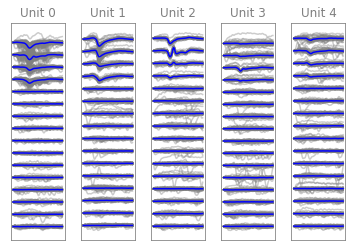

In [24]:
w_wf = sw.plot_unit_waveforms(sorting=sorting_KL_split, recording=recording_f, unit_ids=range(5))

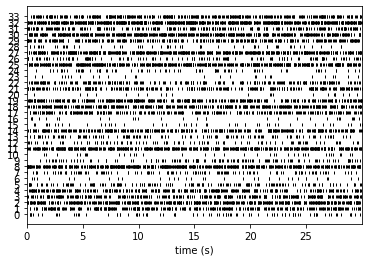

In [25]:
w_rs = sw.plot_rasters(sorting_KL_split)

In [26]:
print('Units', sorting_KL_split.get_unit_ids())

Units [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


We can now perform some automatic curation by thresholding low snr units on the split sorting result

In [30]:
sorting_KL_split_curated = st.curation.threshold_snr(recording=recording, sorting=sorting_KL_split, threshold=5)
print('Curated Units', sorting_KL_split_curated.get_unit_ids())

Curated Units [0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 33]


### Manual curation

To perform manual curation we will export the data to Phy. 

In [31]:
st.postprocessing.export_to_phy(recording_f, 
                                sorting_KL_split, output_folder='phy_KL_split', 
                                grouping_property='group')

In [32]:
%%capture --no-display
!phy template-gui phy_KL_split/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [33]:
sorting_KL_split_curated = se.PhySortingExtractor('phy_KL_split/')

In [34]:
print(len(sorting_KL_split_curated.get_unit_ids()))

34


### Some more spike sorting!

If you have other sorters installed, you can try to run them:

In [35]:
sorting_MS4 = sorters.run_mountainsort4(recording_f, grouping_property='group',
                                        adjacency_radius=50)

AssertionError: This sorter mountainsort4 is not installed.
        Please install it with:  

       >>> pip install ml_ms4alg

    More information on mountainsort at:
      * https://github.com/flatironinstitute/mountainsort
     

In [ ]:
len(sorting_MS4.get_unit_ids())

In [ ]:
st.postprocessing.export_to_phy(recording_f, sorting_MS4, output_folder='phy_MS4', grouping_property='group')

In [ ]:
%%capture --no-display
!phy template-gui  phy_MS4/params.py

In [ ]:
sorting_MS4_curated = se.PhySortingExtractor('phy_MS4')

### Comparison with ground-truth

MEArec recordings are simulated, therefore we know ground truth information about the spiking times. 
We can load the ground truth `SortingExtractor` as:

In [36]:
sorting_gt = se.MEArecSortingExtractor(recording_file)

Now we can compare the sorting output to the ground truth information:

In [41]:
cmp_KL = sc.compare_sorter_to_ground_truth(sorting_gt, 
                                           sorting_KL_split, 
                                           min_accuracy=0.5)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [38]:
cmp_KL.get_performance()

NameError: name 'cmp_KL' is not defined

In [ ]:
cmp_KL.get_performance(method='pooled_with_average')

In [ ]:
cmp_MS4 = sc.compare_sorter_to_ground_truth(sorting_gt, 
                                                       sorting_MS4, 
                                                       min_accuracy=0.5)

In [ ]:
cmp_MS4.get_performance()

In [ ]:
cmp_MS4.get_performance(method='pooled_with_average')

## Exercise) Can you improve the performance with manual curation?

### Multi-sorting comparison

Finally, we can compare KL and SC (or more) and automatically curate the sorting output by retaining the matching units between the two (or more) sorters. We will use the `compare_multiple_sorters` function.
The multi sorting comparison builds a graph with all the units from the different sorters, connected with their agreement score. We can use this to extract agreement sorting.

In [43]:
msc = sc.compare_multiple_sorters(sorting_list=[sorting_KL_split, 
                                                sorting_MS4], 
                                  name_list=['KL', 'MS4'],
                                  min_accuracy=0.5, verbose=True)

NameError: name 'sorting_MS4' is not defined

In [ ]:
w_mcp = sw.plot_multicomp_graph(msc)

In [ ]:
sorting_agreement = msc.get_agreement_sorting(minimum_matching=2)

In [ ]:
print('Klusta units', len(sorting_KL_split.get_unit_ids()))
print('Mountainsort units', len(sorting_MS4.get_unit_ids()))
print('Agreement units', len(sorting_agreement.get_unit_ids()))

We can still inspect the agreement sorting using Phy:

In [ ]:
st.postprocessing.export_to_phy(recording_f, 
                                sorting_agreement, 
                                output_folder='phy_AGR', 
                                grouping_property='group')

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

### Comparison with ground truth

In [42]:
cmp_agr_gt = sc.compare_sorter_to_ground_truth(sorting_gt, sorting_agreement)

NameError: name 'sorting_agreement' is not defined

In [ ]:
cmp_agr_gt.get_performance()

### Save sorting output

In [ ]:
se.MdaSortingExtractor.write_sorting(sorting_agreement, 'firings_agr.mda')

In [ ]:
se.MdaSortingExtractor.write_sorting(sorting_MS4, 'firings_MS4.mda')